In [15]:
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [30]:
logs = pickle.loads(open('/misc/vlgscratch2/LecunGroup/anant/nlp/results_collatepad_bilstm1Layer_5label_adam_lrdecay_1200seqlen.pkl', 'r').read())

In [24]:
logs.keys()

['loss_log', 'val_loss_log', 'step_log', 'train_acc_log']

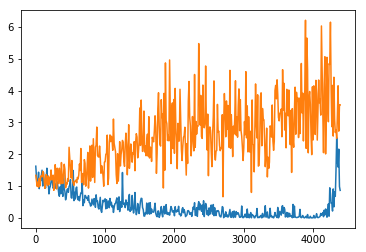

In [31]:
plt.plot(logs['step_log'], logs['loss_log'])
plt.plot(logs['step_log'], logs['val_loss_log'])

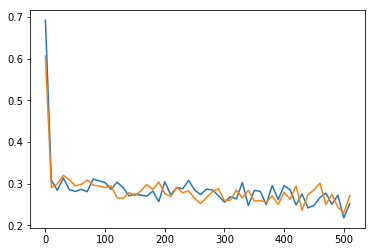

In [19]:
plt.plot(logs['step_log'], logs['loss_log'])
plt.plot(logs['step_log'], logs['val_loss_log'])

## Preprocessing and Analysis by summary extraction

In [1]:
import re
import string
def ext_summ(raw, _str):
    st_ind = raw.index(_str)
    if '\n\n' in raw[st_ind:]:
        _break = raw[st_ind:].index('\n\n')
    elif '.\n' in raw[st_ind:]:
        _break = raw[st_ind:].index('.\n')
            
    raw = raw[st_ind:st_ind+_break].replace(_str, '')
    raw = re.sub('\[\*\*.*\*\*\]|_', ' ', raw).replace('  ', ' ')
    fine = []
    for s in raw.split('\n'):        
        s = s.translate(None, string.punctuation).strip(' ')
        if len(s):
            fine.append(s)
    return ', '.join(fine)

In [2]:
import csv
_count = 0
dd = 0
fd = 0
both = 0
summaries = []
hadm = []
with open('/misc/vlgscratch2/LecunGroup/anant/nlp/mimic/mimic/NOTEEVENTS.csv', 'rb') as f:
    rea = csv.reader(f, delimiter=',', quotechar='"')
    _ = next(rea)
    for _,row in enumerate(rea):
        _count +=1
        isdd, isfd = False, False        
        row[-1] = row[-1].lower()
        if 'discharge diagnosis:' in row[-1]:
            dd +=1
            isdd = True
            summaries.append([row[2], ext_summ(row[-1], 'discharge diagnosis:')])
        if 'final diagnosis:' in row[-1]:
            fd +=1
            isfd = True
            summaries.append([row[2], ext_summ(row[-1], 'final diagnosis:')])
        if isdd and isfd:
            both += 1
        if isdd or isfd:            
            hadm.append(row[2])
print _count, dd, fd, both , len(list(set(hadm)))

2083180 41972 2181 1613 41327


In [3]:
from collections import Counter
label_fd = {}
adm_label = {}
with open('/misc/vlgscratch2/LecunGroup/anant/nlp/mimic/mimic/DIAGNOSES_ICD.csv', 'rb') as f:
    rea = csv.reader(f, delimiter=',', quotechar='"')
    _ = next(rea)
    for _,row in enumerate(rea):
#         if row[-2].isdigit() and int(row[-2])!=1:
#             continue
        try:
            label_fd[row[-1]].append(row[2])
        except:
            label_fd[row[-1]] = [row[2]]
        try:
            adm_label[row[2]].append(row[-1])
        except:
            adm_label[row[2]] = [row[-1]]
            
top_labels = [(_[0], len(_[1])) for _ in sorted(label_fd.iteritems(), key=lambda (x,y):len(y), reverse=True)[:50]]

In [137]:
label_ids = [_[0] for _ in top_labels]
final_data = {}
final_summ_count = 0
for note in summaries:
    if adm_label.get(note[0]):
        for _ in adm_label[note[0]]:
            if _ in label_ids:

                final_summ_count +=1
                break
final_summ_count        

21263

In [33]:
len(final_data)

41719

In [14]:
_labels = [_[0] for _ in top_labels]
final_data = []
for note in summaries:
    if adm_label.get(note[0]):
        _l = ','.join([_ for _ in adm_label[note[0]] if _ in _labels ])
        if len(_l):
            final_data.append(note[:2]+[_l])

with open('../data/summaries_labels.csv', 'wb') as f:
    wri = csv.writer(f, delimiter=',', quotechar='"')
    wri.writerows(final_data)                

In [22]:
with open('../data/top50_labels.csv', 'wb') as f:
    wri = csv.writer(f, delimiter=',', quotechar='"')
    wri.writerows(top_labels) 

In [ ]:
# freq dist of discharge summary per hadm to see if learning a seq of discharge summary 
# is logical considering only diagnosis summary is taken into account.
# total notes: 2083180
# total hadm: 58362

# get maxm # of clean notes with valid labels (seq_num 0 or all)

# Summary extracted:
# total # of notes: 44153 (out of total 59k notes)
# total hadm: 41327


# total notes with top 50 labels: 240775
# summary extracted notes with top 50 labels: 41719
# summary extracted notes with top 50 labels with seq_num 0: 21263